In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from sklearn.preprocessing import StandardScaler


import pymc as pm


# Problem 1

Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 dataset. The heights listed below were recorded in the !Kung census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [2]:
df = pd.read_csv('./data/Howell1.csv',sep=';')

df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


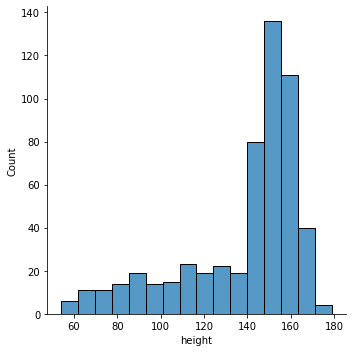

In [3]:
sns.displot(df, x='height')

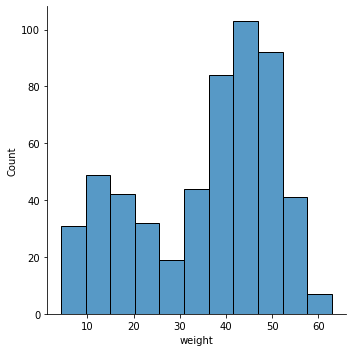

In [4]:
sns.displot(df, x='weight')

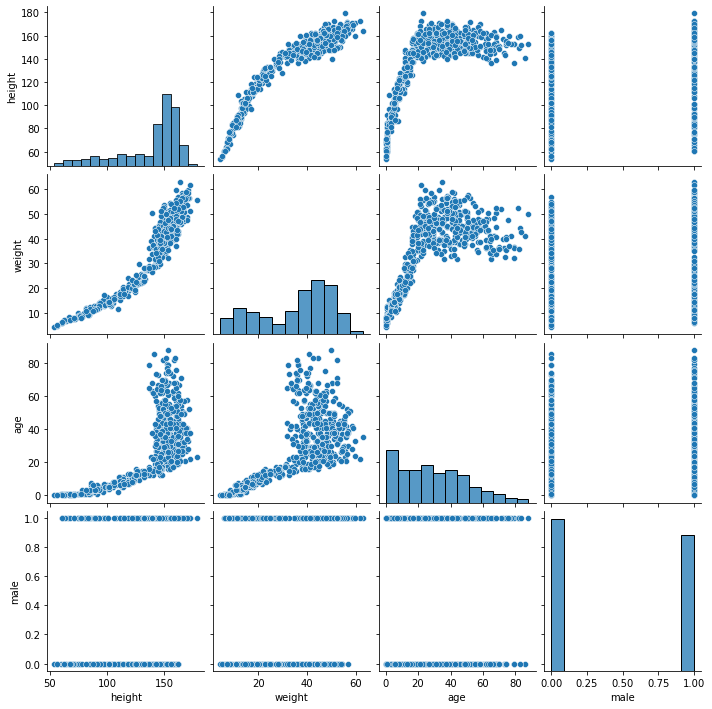

In [5]:
sns.pairplot(df)

<AxesSubplot:xlabel='age', ylabel='weight'>

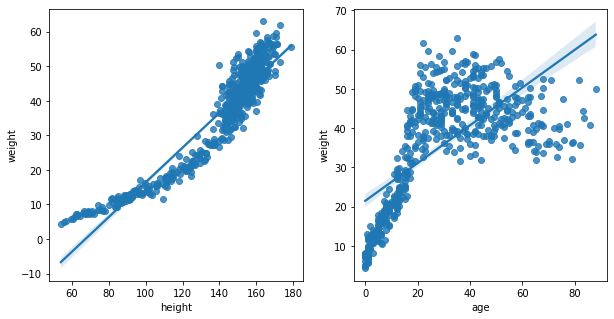

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.regplot(x='height', y='weight', data=df)

plt.subplot(122)
sns.regplot(x='age', y='weight', data=df)

In [7]:
# df['height'] = (df['height'] - np.mean(df['height'])) / np.std(df['height'])

# scaler = StandardScaler()
# df['height'] = scaler.fit_transform(df['height'].values.reshape(-1, 1))
# df['weight'] = scaler.fit_transform(df['weight'].values.reshape(-1, 1))
# df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))

In [9]:
# How to do stuff in pm - older framework, may be better but unclear
with pm.Model() as never_explained_why_pm_need_this:
    pm.Normal('name', mu=2, sigma=1)

### What is numpyro doing?

It took me a long time to figure this out as "model" code in numpyro is incredibly poorly explained or documented, but a "model" function appears to be a function that is embedded in a function, won't work outside of other Numpyro functions, and do "some stuff" that isn't outputted but needs to be done to work inside a numpyro optimizer like MCMC or SVI

It's unclear how it interacts with the rest of the numpyro framework since every example I see there are a bunch of "stuff" in the form of variables of numpyro.sample that is declared within the model function, nothing appears to be output or explicitly declared as a model output, and the whole function is then passed into a black box from which results are spit out

There do seem to be a set of inference algorithms implemented.  SVI is one, as is NUTS which is a MCMC sampler.  Either would work here 

In [25]:
def model(height, weight):
    
#     mu = numpyro.sample("mu", dist.Normal(160,20))
#     sigma = numpyro.sample("sigma", dist.Uniform(0,50))
#     mu = numpyro.sample("mu", dist.Normal(0.0, 0.5))
#     sigma = numpyro.sample("sigma", dist.Uniform(0.0,0.5))
    

    H = height * numpyro.sample("H", dist.Normal(160,20))
    W = weight * numpyro.sample("W", dist.Normal(40,20))
    
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    numpyro.sample('obs', dist.Normal(H, sigma), obs=weight)
    
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(random.PRNGKey(0), height=df['height'].values, weight=df['weight'].values)

mcmc.print_summary()


sample: 100%|█| 3000/3000 [00:04<00:00, 642.65it/s, 3 steps of size 8.02e-01. ac



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         H      0.94      0.01      0.94      0.91      0.96   2030.41      1.00
         W     40.89     20.17     40.44      6.14     71.53   1744.78      1.00
     sigma      0.34      0.01      0.34      0.33      0.36   1758.38      1.00

Number of divergences: 0


In [26]:
mcmc.get_samples()

{'H': DeviceArray([0.9418955 , 0.9306904 , 0.9330354 , ..., 0.955294  ,
              0.94400024, 0.9279177 ], dtype=float32),
 'W': DeviceArray([54.674408, 43.899174, 35.122448, ..., 57.430473, 52.54084 ,
              21.807632], dtype=float32),
 'sigma': DeviceArray([0.3407014 , 0.35657343, 0.3450971 , ..., 0.33707798,
              0.33979493, 0.3381509 ], dtype=float32)}